<a href="https://colab.research.google.com/github/JuliaKoryukova/Kaggle/blob/main/Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений


# Решение на kaggle

https://www.kaggle.com/competitions/journey-springfield


**Юлия_Корюкова_94932239**

### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

10.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

unzip:  cannot find or open /content/gdrive/MyDrive/journey-springfield.zip, /content/gdrive/MyDrive/journey-springfield.zip.zip or /content/gdrive/MyDrive/journey-springfield.zip.ZIP.


In [ ]:
!ls train

ls: cannot access 'train': No such file or directory


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 18 17:47:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В тесте 990 картинок, для которых необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже исспользуется враппер над датасетом для удобной работы.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Переопределяется метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# Установить Kaggle API
!pip install kaggle

# Загрузить kaggle.json
from google.colab import files
files.upload()

# Переместить kaggle.json в папку .kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Загрузить данные соревнования
!kaggle competitions download -c journey-springfield
!unzip journey-springfield.zip -d ./data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: ./data/train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: ./data/tr

In [ ]:
# директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/data/train/simpsons_dataset')
TEST_DIR = Path('/content/data/testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Просмотр героев внутри датасета.

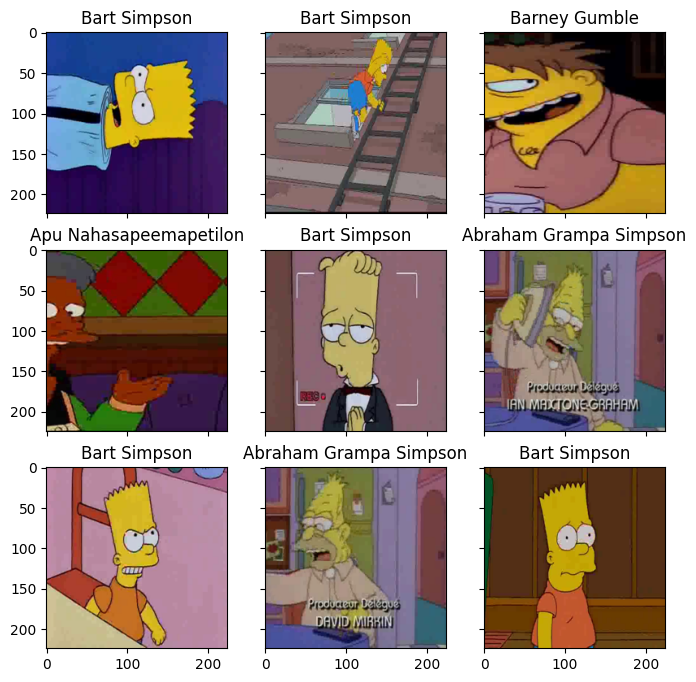

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети


*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запуск обучения сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5842791133583316


epoch:  50%|█████     | 1/2 [02:19<02:19, 139.95s/it]


Epoch 001 train_loss: 2.5843     val_loss 1.9712 train_acc 0.2852 val_acc 0.4540
loss 1.5865460667149096


epoch: 100%|██████████| 2/2 [04:28<00:00, 134.14s/it]


Epoch 002 train_loss: 1.5865     val_loss 1.3695 train_acc 0.5666 val_acc 0.6192


Построение кривых обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

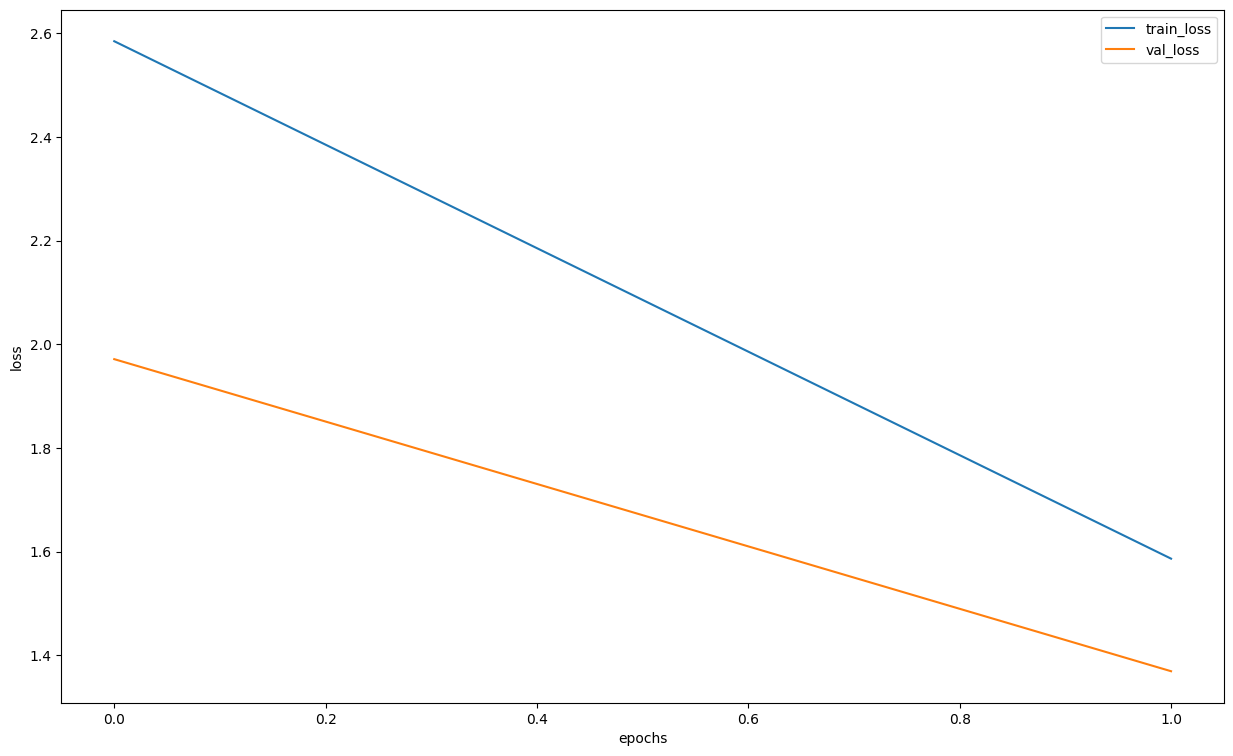

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычисление целевой метрики f1-score на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.5


Визуализация,  чтобы посмотреть насколько сеть уверена в своих ответах.

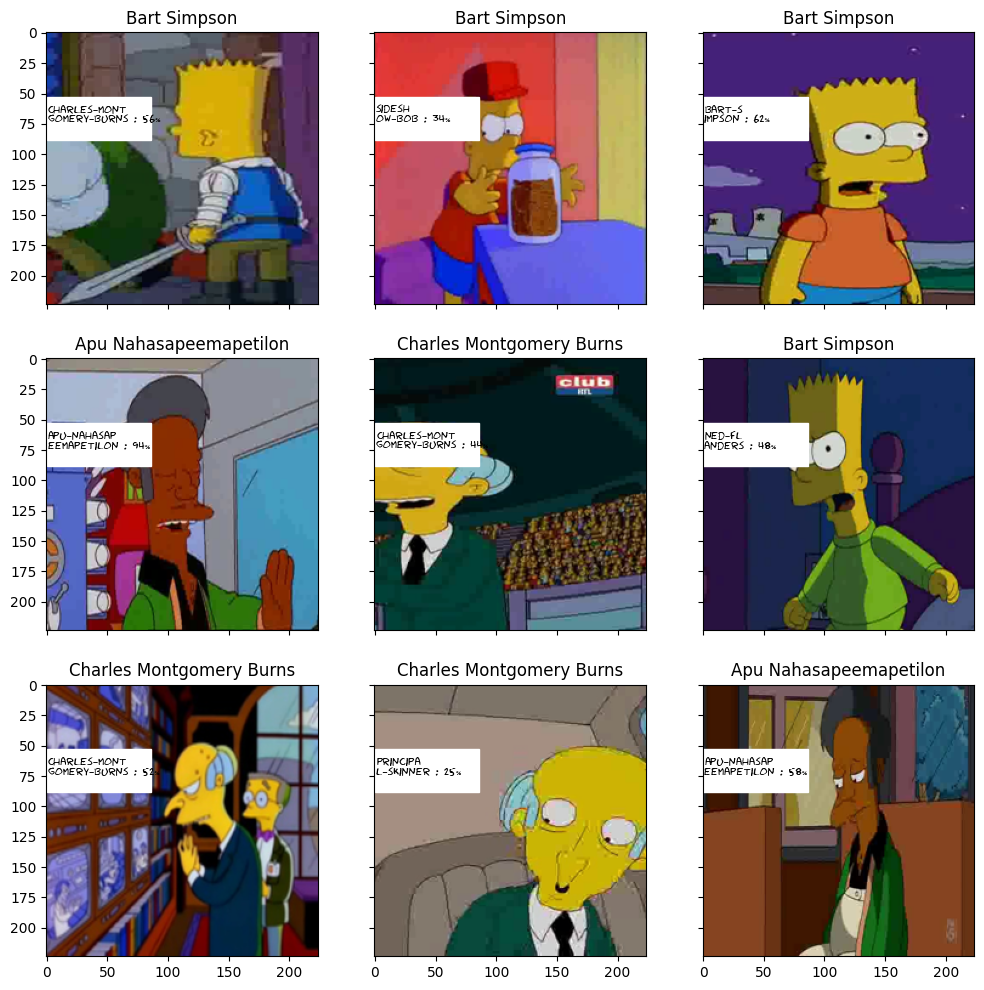

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

data  gdrive  journey-springfield.zip  label_encoder.pkl  sample_data


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/data/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

# Улучшение

Несколько срочных улучшений для сети:

*  Дальнейшее обучение и изменение гиперпараметров
*  learning rate, batch size, нормализация картинки
*  Добавление пуллингов и батч норм
*  AdamW
* ResNet и Inception
* Данных не очень много, можно их аугументировать и  доучититься на новом датасете
* Aнсамбли


![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## Улучшение модели. Версия 1

Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from tqdm import tqdm
from PIL import Image

In [ ]:
# Основные параметры
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Аугментация данных
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(RESCALE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(RESCALE_SIZE),
    transforms.CenterCrop(RESCALE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Датасет
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, transform):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.transform = transform
        if self.mode not in DATA_MODES:
            raise NameError(f"{self.mode} is not correct; correct modes: {DATA_MODES}")

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
# Простейшая сеть
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Добавляем адаптивный пуллинг
        )
        self.fc = nn.Linear(512, n_classes)  # Размер соответствует выходу адаптивного пуллинга

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)  # Превращаем в вектор
        logits = self.fc(x)
        return logits

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
dummy_input = torch.randn(1, 3, RESCALE_SIZE, RESCALE_SIZE).to(DEVICE)
output = simple_cnn(dummy_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 42])


In [ ]:
# Fine-tuning ResNet
class FineTunedResNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # Заморозить параметры
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

Функции для обучения

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        processed_data += inputs.size(0)

    # Проверяем processed_data перед делением
    if processed_data == 0:
        return 0.0, 0.0

    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss, running_corrects, processed_data = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
    return running_loss / processed_data, running_corrects.cpu().numpy() / processed_data

In [ ]:
def train_model(train_loader, val_loader, model, epochs, batch_size):
    opt = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(opt, T_max=10)
    criterion = nn.CrossEntropyLoss()
    history = []

    for epoch in tqdm(range(epochs), desc="Training"):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        history.append((train_loss, train_acc, val_loss, val_acc))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return history

In [ ]:
# Ансамблирование
def ensemble_predict(models, test_loader):
    final_logits = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            ensemble_outputs = [model(inputs).cpu() for model in models]
            final_logits.append(torch.stack(ensemble_outputs).mean(dim=0))
    return torch.cat(final_logits).numpy()

In [ ]:
# Создание моделей
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
train_dataset = SimpsonsDataset(train_files, mode='train', transform=train_transform)
val_dataset = SimpsonsDataset(val_files, mode='val', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

n_classes = len(np.unique(train_val_labels))
simple_model = SimpleCnn(n_classes).to(DEVICE)
resnet_model = FineTunedResNet(n_classes).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.5MB/s]


In [ ]:
# Обучение моделей
history_simple = train_model(train_loader, val_loader, simple_model, epochs=20, batch_size=64)
history_resnet = train_model(train_loader, val_loader, resnet_model, epochs=20, batch_size=64)

Training:   5%|▌         | 1/20 [03:45<1:11:29, 225.76s/it]

Epoch 1/20 - Train Loss: 1.3283, Val Loss: 0.6003, Train Acc: 0.6421, Val Acc: 0.8433


Training:  10%|█         | 2/20 [07:16<1:05:08, 217.12s/it]

Epoch 2/20 - Train Loss: 1.2523, Val Loss: 0.6496, Train Acc: 0.6599, Val Acc: 0.8307


Training:  15%|█▌        | 3/20 [10:47<1:00:43, 214.33s/it]

Epoch 3/20 - Train Loss: 1.2065, Val Loss: 0.5742, Train Acc: 0.6752, Val Acc: 0.8485


Training:  20%|██        | 4/20 [14:18<56:43, 212.73s/it]  

Epoch 4/20 - Train Loss: 1.1476, Val Loss: 0.4824, Train Acc: 0.6883, Val Acc: 0.8718


Training:  25%|██▌       | 5/20 [17:49<53:02, 212.16s/it]

Epoch 5/20 - Train Loss: 1.0661, Val Loss: 0.4466, Train Acc: 0.7114, Val Acc: 0.8833


Training:  30%|███       | 6/20 [21:18<49:17, 211.23s/it]

Epoch 6/20 - Train Loss: 1.0070, Val Loss: 0.3913, Train Acc: 0.7290, Val Acc: 0.9005


Training:  35%|███▌      | 7/20 [24:50<45:49, 211.50s/it]

Epoch 7/20 - Train Loss: 0.9575, Val Loss: 0.3499, Train Acc: 0.7374, Val Acc: 0.9146


Training:  40%|████      | 8/20 [28:21<42:15, 211.30s/it]

Epoch 8/20 - Train Loss: 0.8871, Val Loss: 0.3378, Train Acc: 0.7603, Val Acc: 0.9148


Training:  45%|████▌     | 9/20 [31:54<38:48, 211.64s/it]

Epoch 9/20 - Train Loss: 0.8714, Val Loss: 0.3315, Train Acc: 0.7662, Val Acc: 0.9196


Training:  50%|█████     | 10/20 [35:24<35:12, 211.25s/it]

Epoch 10/20 - Train Loss: 0.8208, Val Loss: 0.3207, Train Acc: 0.7797, Val Acc: 0.9220


Training:  55%|█████▌    | 11/20 [38:55<31:40, 211.17s/it]

Epoch 11/20 - Train Loss: 0.8270, Val Loss: 0.3207, Train Acc: 0.7731, Val Acc: 0.9220


Training:  60%|██████    | 12/20 [42:24<28:04, 210.57s/it]

Epoch 12/20 - Train Loss: 0.8486, Val Loss: 0.3138, Train Acc: 0.7729, Val Acc: 0.9234


Training:  65%|██████▌   | 13/20 [45:52<24:28, 209.85s/it]

Epoch 13/20 - Train Loss: 0.8465, Val Loss: 0.3135, Train Acc: 0.7704, Val Acc: 0.9238


Training:  70%|███████   | 14/20 [49:24<21:03, 210.52s/it]

Epoch 14/20 - Train Loss: 0.8570, Val Loss: 0.3464, Train Acc: 0.7696, Val Acc: 0.9159


Training:  75%|███████▌  | 15/20 [52:58<17:37, 211.48s/it]

Epoch 15/20 - Train Loss: 0.8975, Val Loss: 0.3500, Train Acc: 0.7527, Val Acc: 0.9165


Training:  80%|████████  | 16/20 [56:30<14:06, 211.52s/it]

Epoch 16/20 - Train Loss: 0.9224, Val Loss: 0.3541, Train Acc: 0.7493, Val Acc: 0.9121


Training:  85%|████████▌ | 17/20 [1:00:01<10:34, 211.47s/it]

Epoch 17/20 - Train Loss: 0.9387, Val Loss: 0.3682, Train Acc: 0.7429, Val Acc: 0.9070


Training:  90%|█████████ | 18/20 [1:03:32<07:02, 211.20s/it]

Epoch 18/20 - Train Loss: 0.9574, Val Loss: 0.3565, Train Acc: 0.7437, Val Acc: 0.9138


Training:  95%|█████████▌| 19/20 [1:07:02<03:31, 211.11s/it]

Epoch 19/20 - Train Loss: 0.9576, Val Loss: 0.4277, Train Acc: 0.7436, Val Acc: 0.8928


Training: 100%|██████████| 20/20 [1:10:35<00:00, 211.76s/it]


Epoch 20/20 - Train Loss: 0.9540, Val Loss: 0.3794, Train Acc: 0.7402, Val Acc: 0.9049


Training:   5%|▌         | 1/20 [03:16<1:02:07, 196.16s/it]

Epoch 1/20 - Train Loss: 2.7095, Val Loss: 2.0694, Train Acc: 0.2661, Val Acc: 0.4931


Training:  10%|█         | 2/20 [06:28<58:12, 194.05s/it]  

Epoch 2/20 - Train Loss: 2.1864, Val Loss: 1.7295, Train Acc: 0.4258, Val Acc: 0.5711


Training:  15%|█▌        | 3/20 [09:41<54:51, 193.61s/it]

Epoch 3/20 - Train Loss: 2.0242, Val Loss: 1.5960, Train Acc: 0.4600, Val Acc: 0.5904


Training:  20%|██        | 4/20 [12:56<51:46, 194.19s/it]

Epoch 4/20 - Train Loss: 1.9319, Val Loss: 1.4843, Train Acc: 0.4783, Val Acc: 0.6196


Training:  25%|██▌       | 5/20 [16:10<48:30, 194.01s/it]

Epoch 5/20 - Train Loss: 1.8612, Val Loss: 1.4452, Train Acc: 0.4950, Val Acc: 0.6337


Training:  30%|███       | 6/20 [19:23<45:10, 193.58s/it]

Epoch 6/20 - Train Loss: 1.8493, Val Loss: 1.4136, Train Acc: 0.4958, Val Acc: 0.6246


Training:  35%|███▌      | 7/20 [22:36<41:56, 193.57s/it]

Epoch 7/20 - Train Loss: 1.8182, Val Loss: 1.3862, Train Acc: 0.5068, Val Acc: 0.6378


Training:  40%|████      | 8/20 [25:48<38:37, 193.10s/it]

Epoch 8/20 - Train Loss: 1.7984, Val Loss: 1.4009, Train Acc: 0.5114, Val Acc: 0.6290


Training:  45%|████▌     | 9/20 [29:02<35:25, 193.21s/it]

Epoch 9/20 - Train Loss: 1.7851, Val Loss: 1.3746, Train Acc: 0.5155, Val Acc: 0.6399


Training:  50%|█████     | 10/20 [32:16<32:15, 193.55s/it]

Epoch 10/20 - Train Loss: 1.7620, Val Loss: 1.3672, Train Acc: 0.5218, Val Acc: 0.6404


Training:  55%|█████▌    | 11/20 [35:31<29:06, 194.02s/it]

Epoch 11/20 - Train Loss: 1.7821, Val Loss: 1.3672, Train Acc: 0.5126, Val Acc: 0.6404


Training:  60%|██████    | 12/20 [38:45<25:50, 193.78s/it]

Epoch 12/20 - Train Loss: 1.7651, Val Loss: 1.3671, Train Acc: 0.5201, Val Acc: 0.6439


Training:  65%|██████▌   | 13/20 [41:58<22:34, 193.55s/it]

Epoch 13/20 - Train Loss: 1.7891, Val Loss: 1.3740, Train Acc: 0.5141, Val Acc: 0.6374


Training:  70%|███████   | 14/20 [45:12<19:23, 193.89s/it]

Epoch 14/20 - Train Loss: 1.7837, Val Loss: 1.3649, Train Acc: 0.5154, Val Acc: 0.6408


Training:  75%|███████▌  | 15/20 [48:25<16:07, 193.57s/it]

Epoch 15/20 - Train Loss: 1.7803, Val Loss: 1.3470, Train Acc: 0.5153, Val Acc: 0.6479


Training:  80%|████████  | 16/20 [51:39<12:54, 193.53s/it]

Epoch 16/20 - Train Loss: 1.7898, Val Loss: 1.3721, Train Acc: 0.5093, Val Acc: 0.6316


Training:  85%|████████▌ | 17/20 [54:56<09:44, 194.69s/it]

Epoch 17/20 - Train Loss: 1.7951, Val Loss: 1.3293, Train Acc: 0.5111, Val Acc: 0.6479


Training:  90%|█████████ | 18/20 [58:12<06:29, 194.96s/it]

Epoch 18/20 - Train Loss: 1.7734, Val Loss: 1.3414, Train Acc: 0.5146, Val Acc: 0.6420


Training:  95%|█████████▌| 19/20 [1:01:34<03:17, 197.27s/it]

Epoch 19/20 - Train Loss: 1.7753, Val Loss: 1.3145, Train Acc: 0.5104, Val Acc: 0.6442


Training: 100%|██████████| 20/20 [1:04:47<00:00, 194.38s/it]

Epoch 20/20 - Train Loss: 1.7440, Val Loss: 1.2855, Train Acc: 0.5268, Val Acc: 0.6538


In [ ]:
# Функция предсказания с ансамблированием моделей
def ensemble_predict(models, dataloader):
    all_probs = []
    for model in models:
        model.eval()  # Переводим модель в режим инференса
        model.to(DEVICE)
        logits = []

        with torch.no_grad():
            for inputs in dataloader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                logits.append(outputs.cpu())

        # Преобразуем список logits в массив
        logits = torch.cat(logits, dim=0)
        probs = torch.nn.functional.softmax(logits, dim=1).numpy()  # Применяем softmax для получения вероятностей
        all_probs.append(probs)

    # Среднее по всем моделям
    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs

In [ ]:
# Предсказания с ансамблированием
test_dataset = SimpsonsDataset(test_files, mode="test", transform=val_transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = ensemble_predict([simple_model, resnet_model], test_loader)

In [ ]:
# Итоговые результаты
preds = np.argmax(probs, axis=1)
test_filenames = [path.name for path in test_dataset.files]
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.to_csv('submission.csv', index=False)

In [ ]:
import re

# Функция для сортировки имен файлов в естественном порядке
def natural_key(text):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', text)]

# Преобразование предсказанных индексов в имена классов
predicted_classes = label_encoder.inverse_transform(preds)

# Формирование итогового DataFrame
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': predicted_classes})

# Сортировка DataFrame по `Id` в естественном порядке
my_submit = my_submit.sort_values(by='Id', key=lambda col: col.map(natural_key))

# Сохранение в CSV
my_submit.to_csv('submission.csv', index=False)

# Вывод первых строк для проверки
print(my_submit.head())

           Id      Expected
0    img0.jpg  nelson_muntz
1    img1.jpg  bart_simpson
112  img2.jpg  mayor_quimby
223  img3.jpg  nelson_muntz
334  img4.jpg  lisa_simpson


## Улучшение модели. Версия 2

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
# --- Глобальные настройки ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESCALE_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 20
DATA_PATH = Path('/content/data/train/simpsons_dataset')
TEST_PATH = Path('/content/data/testset/testset')

In [ ]:
# --- Датасет ---
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        else:
            self.labels = None

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]) if mode == 'train' else transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_path = self.files[index]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        if self.mode == 'test':
            return image
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            return image, label_id.item()

In [ ]:
# --- Подготовка данных ---
train_val_files = list(DATA_PATH.rglob("*.jpg"))
train_files, val_files = train_test_split(
    train_val_files,
    test_size=0.25,
    stratify=[path.parent.name for path in train_val_files],
    random_state=42
)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_files = list(TEST_PATH.rglob("*.jpg"))
test_dataset = SimpsonsDataset(test_files, mode='test')

In [ ]:
# --- Балансировка классов ---
train_labels = [path.parent.name for path in train_files]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
sample_weights = [class_weights[train_dataset.label_encoder.transform([path.parent.name])[0]] for path in train_files]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# --- Модель ---
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

n_classes = len(train_dataset.label_encoder.classes_)
model = FineTunedResNet(n_classes).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [ ]:
# --- Обучение ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Training:   5%|▌         | 1/20 [06:06<1:56:03, 366.51s/it]

Epoch 1/20 - Train Loss: 1.8602, Val Loss: 1.3750, Train Acc: 0.5088, Val Acc: 0.6496


Training:  10%|█         | 2/20 [12:08<1:49:06, 363.68s/it]

Epoch 2/20 - Train Loss: 1.1673, Val Loss: 0.8873, Train Acc: 0.6901, Val Acc: 0.7765


Training:  15%|█▌        | 3/20 [18:10<1:42:53, 363.16s/it]

Epoch 3/20 - Train Loss: 0.9585, Val Loss: 0.8518, Train Acc: 0.7431, Val Acc: 0.7904


Training:  20%|██        | 4/20 [24:12<1:36:40, 362.51s/it]

Epoch 4/20 - Train Loss: 0.8316, Val Loss: 0.5601, Train Acc: 0.7758, Val Acc: 0.8579


Training:  25%|██▌       | 5/20 [30:12<1:30:27, 361.81s/it]

Epoch 5/20 - Train Loss: 0.7607, Val Loss: 0.4354, Train Acc: 0.7971, Val Acc: 0.8911


Training:  30%|███       | 6/20 [36:15<1:24:28, 362.05s/it]

Epoch 6/20 - Train Loss: 0.7006, Val Loss: 0.4409, Train Acc: 0.8107, Val Acc: 0.8871


Training:  35%|███▌      | 7/20 [42:10<1:17:57, 359.79s/it]

Epoch 7/20 - Train Loss: 0.6216, Val Loss: 0.4581, Train Acc: 0.8290, Val Acc: 0.8850


Training:  40%|████      | 8/20 [47:56<1:11:04, 355.35s/it]

Epoch 8/20 - Train Loss: 0.5816, Val Loss: 0.3921, Train Acc: 0.8432, Val Acc: 0.9039


Training:  45%|████▌     | 9/20 [53:39<1:04:26, 351.51s/it]

Epoch 9/20 - Train Loss: 0.5581, Val Loss: 0.3375, Train Acc: 0.8511, Val Acc: 0.9177


Training:  50%|█████     | 10/20 [59:18<57:56, 347.66s/it] 

Epoch 10/20 - Train Loss: 0.5115, Val Loss: 0.3136, Train Acc: 0.8622, Val Acc: 0.9211


Training:  55%|█████▌    | 11/20 [1:04:55<51:40, 344.49s/it]

Epoch 11/20 - Train Loss: 0.4704, Val Loss: 0.3152, Train Acc: 0.8746, Val Acc: 0.9190


Training:  60%|██████    | 12/20 [1:10:33<45:38, 342.35s/it]

Epoch 12/20 - Train Loss: 0.4515, Val Loss: 0.2732, Train Acc: 0.8767, Val Acc: 0.9308


Training:  65%|██████▌   | 13/20 [1:16:10<39:46, 340.91s/it]

Epoch 13/20 - Train Loss: 0.4180, Val Loss: 0.2855, Train Acc: 0.8892, Val Acc: 0.9301


Training:  70%|███████   | 14/20 [1:21:48<33:58, 339.80s/it]

Epoch 14/20 - Train Loss: 0.3838, Val Loss: 0.2323, Train Acc: 0.8974, Val Acc: 0.9398


Training:  75%|███████▌  | 15/20 [1:27:26<28:17, 339.44s/it]

Epoch 15/20 - Train Loss: 0.3678, Val Loss: 0.2335, Train Acc: 0.9008, Val Acc: 0.9415


Training:  80%|████████  | 16/20 [1:33:02<22:33, 338.30s/it]

Epoch 16/20 - Train Loss: 0.3516, Val Loss: 0.2139, Train Acc: 0.9047, Val Acc: 0.9461


Training:  85%|████████▌ | 17/20 [1:38:39<16:53, 337.94s/it]

Epoch 17/20 - Train Loss: 0.3360, Val Loss: 0.2097, Train Acc: 0.9113, Val Acc: 0.9478


Training:  90%|█████████ | 18/20 [1:44:14<11:13, 336.96s/it]

Epoch 18/20 - Train Loss: 0.3413, Val Loss: 0.1942, Train Acc: 0.9090, Val Acc: 0.9520


Training:  95%|█████████▌| 19/20 [1:49:52<05:37, 337.43s/it]

Epoch 19/20 - Train Loss: 0.3177, Val Loss: 0.1911, Train Acc: 0.9160, Val Acc: 0.9526


Training: 100%|██████████| 20/20 [1:55:30<00:00, 346.52s/it]

Epoch 20/20 - Train Loss: 0.3162, Val Loss: 0.1899, Train Acc: 0.9153, Val Acc: 0.9536


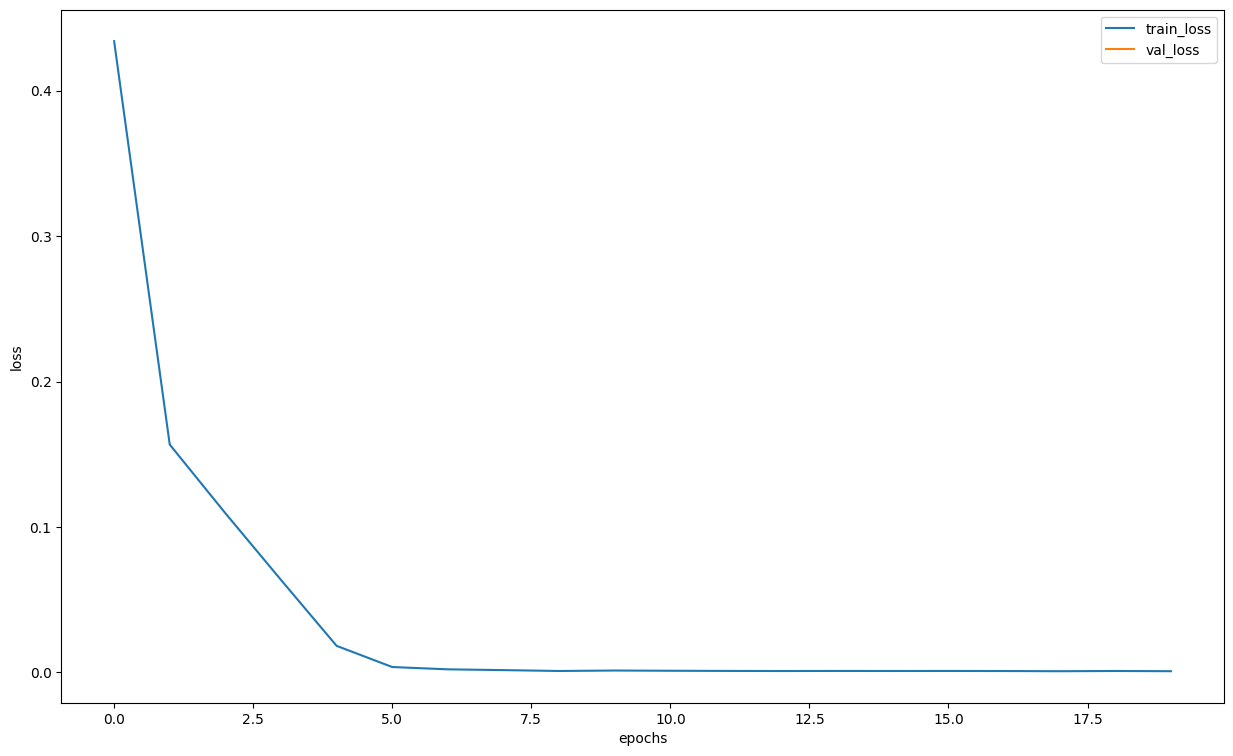

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# --- Предсказания ---
model.eval()
probs = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)
        outputs = torch.softmax(model(images), dim=1)
        probs.append(outputs.cpu().numpy())

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 1.0


In [ ]:
probs = np.concatenate(probs)
preds = train_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.to_csv('submission_2.csv', index=False)

## Улучшение модели. Версия 3

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np

train_on_gpu = torch.cuda.is_available()

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Resnet

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("Количество меток классов: {}".format(n_classes))

Количество меток классов: 42


In [ ]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()

            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.inference_mode():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = model.to(DEVICE)
print("количество для классификации :{}".format(n_classes))
print(model)

количество для классификации :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history_3 = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.4339490397294332


epoch:   5%|▌         | 1/20 [04:34<1:26:48, 274.16s/it]


Epoch 001 train_loss: 0.4339     val_loss 0.4296 train_acc 0.8938 val_acc 0.8999
loss 0.15665763878060707


epoch:  10%|█         | 2/20 [09:03<1:21:25, 271.42s/it]


Epoch 002 train_loss: 0.1567     val_loss 0.2390 train_acc 0.9585 val_acc 0.9434
loss 0.10948426708559131


epoch:  15%|█▌        | 3/20 [13:33<1:16:45, 270.90s/it]


Epoch 003 train_loss: 0.1095     val_loss 0.2620 train_acc 0.9690 val_acc 0.9360
loss 0.06364392799623864


epoch:  20%|██        | 4/20 [18:14<1:13:13, 274.57s/it]


Epoch 004 train_loss: 0.0636     val_loss 0.2356 train_acc 0.9833 val_acc 0.9452
loss 0.01830631365144547


epoch:  25%|██▌       | 5/20 [22:46<1:08:24, 273.64s/it]


Epoch 005 train_loss: 0.0183     val_loss 0.1124 train_acc 0.9961 val_acc 0.9757
loss 0.003747789871501208


epoch:  30%|███       | 6/20 [27:17<1:03:40, 272.89s/it]


Epoch 006 train_loss: 0.0037     val_loss 0.1112 train_acc 0.9994 val_acc 0.9755
loss 0.0021602425580585986


epoch:  35%|███▌      | 7/20 [31:48<58:59, 272.25s/it]


Epoch 007 train_loss: 0.0022     val_loss 0.1095 train_acc 0.9998 val_acc 0.9775
loss 0.0016247788613085617


epoch:  40%|████      | 8/20 [36:20<54:26, 272.23s/it]


Epoch 008 train_loss: 0.0016     val_loss 0.1108 train_acc 0.9997 val_acc 0.9775
loss 0.0010256968689633128


epoch:  45%|████▌     | 9/20 [40:52<49:53, 272.12s/it]


Epoch 009 train_loss: 0.0010     val_loss 0.1092 train_acc 0.9999 val_acc 0.9780
loss 0.0013446686766257186


epoch:  50%|█████     | 10/20 [45:23<45:16, 271.60s/it]


Epoch 010 train_loss: 0.0013     val_loss 0.1102 train_acc 0.9998 val_acc 0.9773
loss 0.001183337011210859


epoch:  55%|█████▌    | 11/20 [49:53<40:41, 271.28s/it]


Epoch 011 train_loss: 0.0012     val_loss 0.1091 train_acc 0.9998 val_acc 0.9780
loss 0.001069329078478607


epoch:  60%|██████    | 12/20 [54:25<36:11, 271.41s/it]


Epoch 012 train_loss: 0.0011     val_loss 0.1103 train_acc 0.9996 val_acc 0.9775
loss 0.0010011679232400522


epoch:  65%|██████▌   | 13/20 [58:56<31:39, 271.37s/it]


Epoch 013 train_loss: 0.0010     val_loss 0.1117 train_acc 0.9999 val_acc 0.9771
loss 0.0010503620463540298


epoch:  70%|███████   | 14/20 [1:03:27<27:06, 271.16s/it]


Epoch 014 train_loss: 0.0011     val_loss 0.1090 train_acc 0.9999 val_acc 0.9780
loss 0.0010219593547066055


epoch:  75%|███████▌  | 15/20 [1:07:57<22:34, 270.96s/it]


Epoch 015 train_loss: 0.0010     val_loss 0.1086 train_acc 0.9998 val_acc 0.9775
loss 0.0010454941739868823


epoch:  80%|████████  | 16/20 [1:12:28<18:03, 270.86s/it]


Epoch 016 train_loss: 0.0010     val_loss 0.1090 train_acc 0.9998 val_acc 0.9778
loss 0.0009983608075572264


epoch:  85%|████████▌ | 17/20 [1:16:57<13:31, 270.50s/it]


Epoch 017 train_loss: 0.0010     val_loss 0.1093 train_acc 0.9998 val_acc 0.9776
loss 0.0008632136265802954


epoch:  90%|█████████ | 18/20 [1:21:29<09:01, 270.67s/it]


Epoch 018 train_loss: 0.0009     val_loss 0.1094 train_acc 0.9999 val_acc 0.9771
loss 0.0010256958078659999


epoch:  95%|█████████▌| 19/20 [1:25:58<04:30, 270.35s/it]


Epoch 019 train_loss: 0.0010     val_loss 0.1076 train_acc 0.9999 val_acc 0.9780
loss 0.0008772802326494367


epoch: 100%|██████████| 20/20 [1:30:28<00:00, 271.41s/it]


Epoch 020 train_loss: 0.0009     val_loss 0.1099 train_acc 0.9999 val_acc 0.9780


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_3)

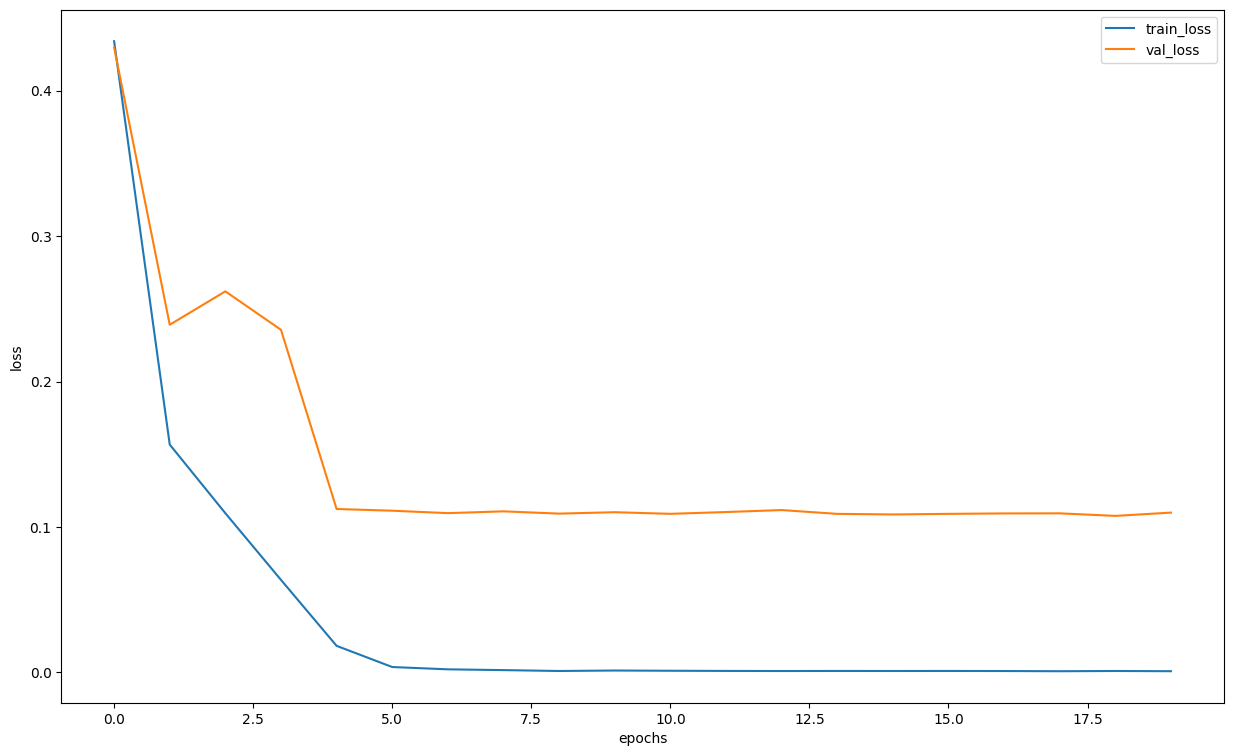

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
probs_im

array([[1.00000000e+00, 3.75631980e-13, 4.02876081e-16, 4.78445550e-08,
        7.57412952e-11, 2.89814322e-14, 7.18788771e-14, 1.54115327e-12,
        1.77596219e-12, 1.30970159e-13, 2.24241258e-15, 1.73582408e-13,
        3.24233655e-19, 1.56525404e-14, 5.22536624e-14, 1.16865484e-11,
        3.93862257e-14, 6.10454742e-12, 2.56297310e-11, 3.67151626e-17,
        1.53912332e-12, 4.23682573e-13, 4.81048523e-13, 8.63481514e-14,
        9.95702984e-15, 4.55525544e-14, 2.95852282e-15, 1.23811700e-13,
        1.34787624e-12, 8.96070327e-14, 7.80255326e-15, 1.73404619e-14,
        1.37727460e-11, 8.41703145e-14, 4.95120880e-16, 9.32853478e-15,
        3.40762032e-13, 8.76442202e-14, 5.89097402e-13, 2.22621858e-15,
        8.34794035e-19, 8.98479081e-16, 1.07786874e-22, 4.60792840e-23,
        3.06259438e-23, 2.72158054e-23, 3.99233480e-23, 9.10997021e-23,
        8.01505336e-23, 3.41883954e-23, 9.18699080e-23, 6.23240202e-22,
        1.57202737e-22, 3.59104094e-23, 1.89286543e-23, 2.209737

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.95


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('submission_3.csv', index=False)